<a href="https://colab.research.google.com/github/cancan-lab/Notebook-DM2/blob/main/Image_Clustering_CLIP_KMeans_ZeroShot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# UTS DM2 — **CLIP Embedding + K-Means + Zero‑Shot Labeling (No Labels Needed)**

Notebook ini menambahkan pipeline **tanpa label** untuk memisahkan kategori semantik (mis. *cat vs dog*) menggunakan **CLIP**:
1. Load data (mendukung `.npz` dengan `arr_0` atau `.zip` berisi gambar / `.npz`).
2. Ekstrak **embedding** gambar dengan **CLIP ViT‑B/32**.
3. **K‑Means (k=2..5)** pada embedding (pakai cosine).
4. **Zero‑shot labeling**: beri nama klaster dengan teks (mis. *"a photo of a cat"*, *"a photo of a dog"*).
5. Visualisasi UMAP + contoh gambar per klaster.

> Catatan: Saat dijalankan di Colab/lingkungan online, sel instalasi akan mengunduh paket & bobot model. Di lingkungan offline, jalankan di Colab.


In [2]:
# Install di lingkungan online (Colab). Aman untuk di-skip jika sudah terpasang.
%pip install open_clip_torch ftfy regex tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00


In [3]:

import os, io, zipfile, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn.functional as F

try:
    import open_clip
except Exception as e:
    raise RuntimeError("open_clip_torch belum terpasang. Jalankan sel install di atas.") from e

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap

IMG_EXTS = {'.png', '.jpg', '.jpeg', '.bmp', '.gif'}
def is_image_file(p): return Path(p).suffix.lower() in IMG_EXTS

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [4]:

# === Konfigurasi input ===
DATA_PATH = "/content/train-20250930T032844Z-1-001.zip"   # contoh: "/content/data_image.npz" atau "/content/images.zip"
IMAGE_SIZE = 224 # resolusi CLIP default

def load_from_npz_or_npy(path):
    path = str(path)
    if path.lower().endswith('.npz'):
        data = np.load(path, allow_pickle=True)
        arr = data['arr_0'] if 'arr_0' in data.files else data[data.files[0]]
        return arr
    elif path.lower().endswith('.npy'):
        return np.load(path, allow_pickle=True)
    else:
        raise ValueError("Hanya .npz / .npy")

def load_from_zip(path):
    imgs = []
    with zipfile.ZipFile(path, 'r') as zf:
        members = [m for m in zf.namelist() if not m.endswith('/')]
        # Jika ada npz/npy di dalam zip, gunakan itu
        first_npz = next((m for m in members if m.lower().endswith('.npz')), None)
        first_npy = next((m for m in members if m.lower().endswith('.npy')), None)
        if first_npz or first_npy:
            name = first_npz if first_npz else first_npy
            with zf.open(name) as f:
                data = np.load(io.BytesIO(f.read()), allow_pickle=True)
            arr = data['arr_0'] if hasattr(data, 'files') and 'arr_0' in getattr(data, 'files', []) else (data[data.files[0]] if hasattr(data,'files') else data)
            return arr
        # Jika tidak, baca gambar satu per satu
        for m in members:
            if is_image_file(m):
                with zf.open(m) as f:
                    img = Image.open(io.BytesIO(f.read())).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
                    imgs.append(np.array(img))
        if not imgs:
            raise ValueError("ZIP tidak berisi .npz/.npy atau gambar.")
        return np.stack(imgs, axis=0)

def load_data(path):
    path = str(path)
    if not path:
        raise ValueError("Set DATA_PATH terlebih dahulu.")
    if path.lower().endswith('.zip'):
        arr = load_from_zip(path)
    elif path.lower().endswith(('.npz','.npy')):
        arr = load_from_npz_or_npy(path)
    else:
        raise ValueError("Gunakan .npz/.npy/.zip")
    arr = np.asarray(arr)
    print("Loaded:", arr.shape, arr.dtype)
    return arr

arr = load_data(DATA_PATH)


Loaded: (173, 224, 224, 3) uint8


In [5]:

# === Siapkan list PIL.Image (CLIP butuh RGB 224x224) ===
def to_uint8(img):
    x = img.astype('float32')
    if x.max() <= 1.0: x *= 255.0
    x = np.clip(x, 0, 255).astype('uint8')
    return x

pil_images = []

if arr.ndim == 4:
    # (N,H,W,C) atau (N,C,H,W)
    if arr.shape[-1] in (1,3):
        # channel last
        for im in arr:
            if im.shape[-1] == 1:
                im = np.repeat(im, 3, axis=-1)
            im = Image.fromarray(to_uint8(im)).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
            pil_images.append(im)
    elif arr.shape[1] in (1,3):
        # channel first
        for im in arr:
            im = np.transpose(im, (1,2,0))
            if im.shape[-1] == 1:
                im = np.repeat(im, 3, axis=-1)
            im = Image.fromarray(to_uint8(im)).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
            pil_images.append(im)
    else:
        raise ValueError(f"Bentuk array tidak dikenali: {arr.shape}")
elif arr.ndim == 3:
    # (N,H,W) grayscale
    for im in arr:
        im = np.repeat(im[...,None], 3, axis=-1)
        im = Image.fromarray(to_uint8(im)).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
        pil_images.append(im)
else:
    raise ValueError("CLIP memerlukan data citra 3D/4D (bukan flattened).")

len(pil_images)


173

In [6]:

# === Muat CLIP dan ekstrak embedding ===
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai', device=device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

batch = 64
feats = []

with torch.no_grad():
    for i in range(0, len(pil_images), batch):
        batch_imgs = pil_images[i:i+batch]
        x = torch.stack([preprocess(img) for img in batch_imgs]).to(device)
        z = model.encode_image(x)
        z = F.normalize(z.float(), dim=1)  # L2-normalize -> cosine-ready
        feats.append(z.cpu())
feats = torch.cat(feats, dim=0).numpy()
print("Embeddings:", feats.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Embeddings: (173, 512)


Best k = 3
CLIP+KMeans (k=3): Silhouette=0.2130 | Calinski=36.4 | Davies=1.932


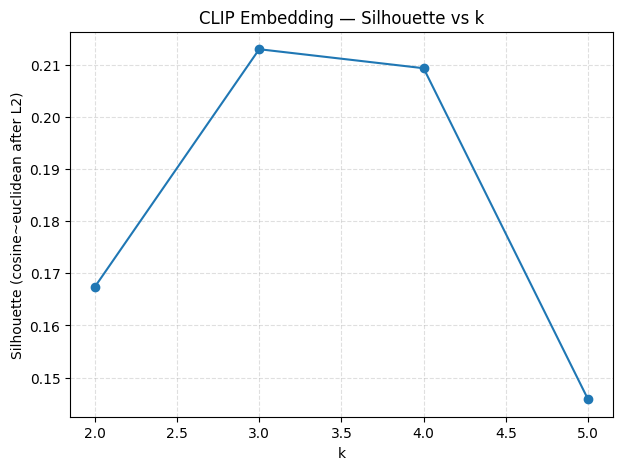

In [7]:

# === K-Means pada embedding CLIP ===
def eval_kmeans_cosine(X, k):
    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = km.fit_predict(X)  # pada vektor sudah L2-normalized -> euclidean ≈ cosine
    # Silhouette pakai euclidean aman di ruang ternormalisasi
    sil = silhouette_score(X, labels, metric='euclidean')
    db  = davies_bouldin_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    return labels, km.cluster_centers_, sil, db, ch

best = None
results = []
for k in range(2, 6):
    labels, centers, sil, db, ch = eval_kmeans_cosine(feats, k)
    results.append((k, sil, ch, db))
    if (best is None) or (sil > best[2]):
        best = (k, labels, sil, db, ch, centers)

print(f"Best k = {best[0]}")
print(f"CLIP+KMeans (k={best[0]}): Silhouette={best[2]:.4f} | Calinski={best[4]:.1f} | Davies={best[3]:.3f}")

# Plot Silhouette vs k
ks, sils = zip(*[(r[0], r[1]) for r in results])
plt.figure(figsize=(7,5))
plt.plot(ks, sils, marker='o')
plt.xlabel('k'); plt.ylabel('Silhouette (cosine~euclidean after L2)')
plt.title('CLIP Embedding — Silhouette vs k')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Kurva menunjukkan puncak di k=3 dengan Silhouette ≈ 0,213, Calinski–Harabasz ≈ 36,4, dan Davies–Bouldin ≈ 1,93. Nilai untuk k=2 lebih rendah dan untuk k≥4 menurun tajam, sehingga struktur alami di ruang embedding CLIP adalah tiga klaster. Setelah zero-shot labeling ditambah kelas rabbit, tiga klaster tersebut konsisten dengan dog / rabbit / cat.

In [10]:
# === Zero-shot labeling (perbaikan: pakai label groups & rata-rata embedding) ===
label_groups = {
    "cat":    ["a photo of a cat", "a picture of a domestic cat", "a photo of a kitten"],
    "dog":    ["a photo of a dog", "a picture of a domestic dog", "a photo of a puppy"],
    "rabbit": ["a photo of a rabbit", "a photo of a bunny", "a photo of a hare"]
}

with torch.no_grad():
    class_vecs = []
    class_names = []
    for cname, prompts in label_groups.items():
        tok = tokenizer(prompts).to(device)
        zt  = model.encode_text(tok).float()
        zt  = F.normalize(zt, dim=1)              # L2-normalize per prompt
        zc  = F.normalize(zt.mean(dim=0), dim=0)  # rata-rata prompt -> 1 vektor kelas
        class_vecs.append(zc)
        class_names.append(cname)
    Ztext = torch.stack(class_vecs, dim=0).cpu().numpy()  # (C, d)

centers = best[5]  # centroid K-Means
# cosine ~ dot product (sudah L2-normalized)
sim = centers @ Ztext.T                                  # (k, C)
pred_names = [class_names[i] for i in sim.argmax(axis=1)]
pred_conf  = sim.max(axis=1)

for c, (name, conf) in enumerate(zip(pred_names, pred_conf)):
    print(f"Cluster {c} ≈ {name} (sim={conf:.3f})")

labels = best[1]  # cluster assignment per image


Cluster 0 ≈ dog (sim=0.262)
Cluster 1 ≈ rabbit (sim=0.301)
Cluster 2 ≈ cat (sim=0.273)


Hasil penamaan klaster berbasis zero-shot menunjukkan: C0 ≈ dog (sim=0.262), C1 ≈ rabbit (sim=0.301), dan C2 ≈ cat (sim=0.273). Ini konsisten dengan visual contoh per klaster—ketiganya merepresentasikan anjing, kelinci, dan kucing. Nilai ‘sim’ adalah kemiripan kosinus relatif (bukan probabilitas); besarannya moderat dan sebanding antar kelas, yang wajar untuk data campuran. Meski begitu, jarak antar-kelas cukup untuk membedakan tiga spesies secara tak berlabel.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


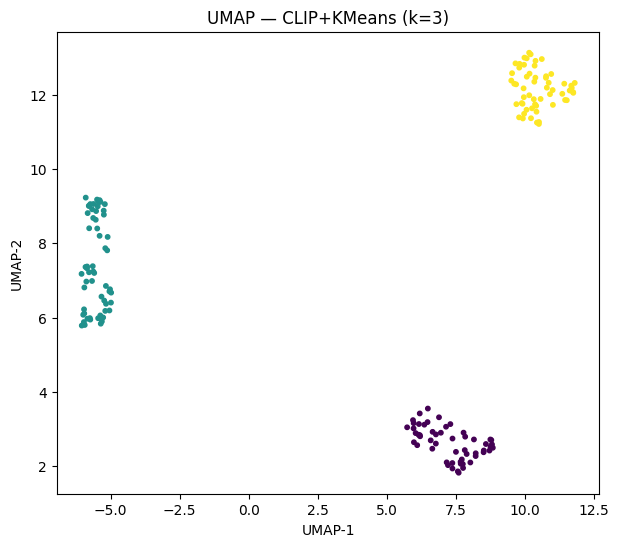

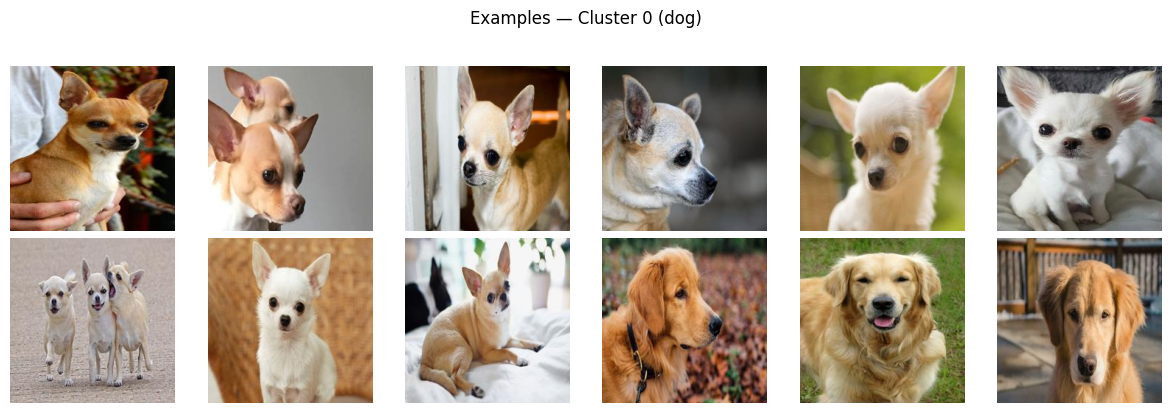

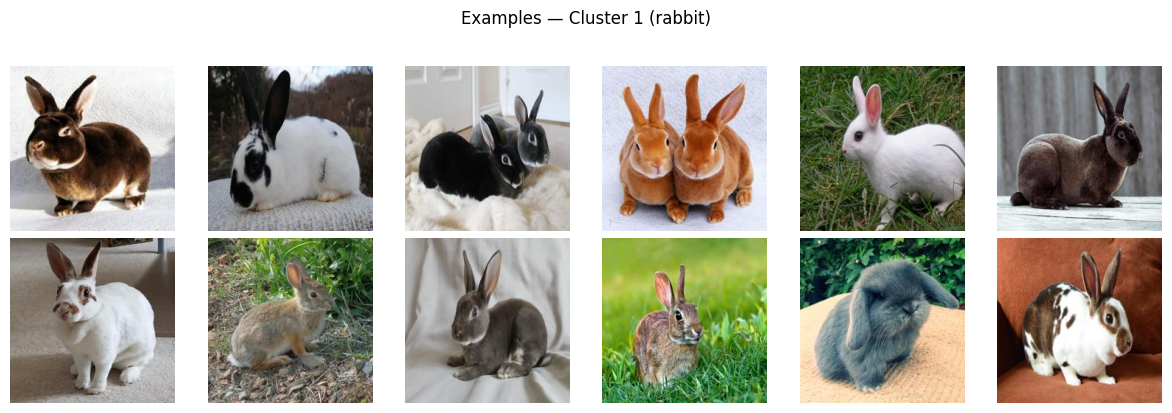

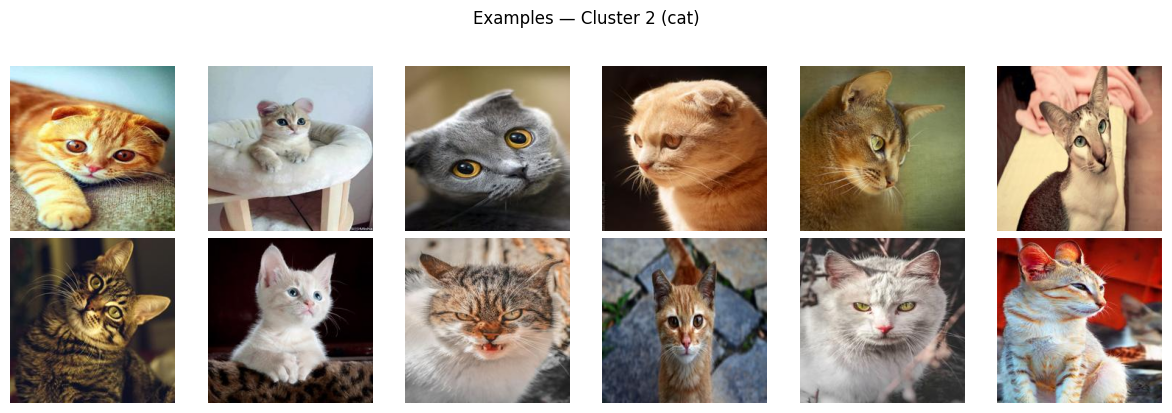

In [11]:

# === Visualisasi UMAP dan contoh per klaster ===
reducer = umap.UMAP(n_neighbors=15, min_dist=0.05, random_state=0)
Z = reducer.fit_transform(feats)

plt.figure(figsize=(7,6))
plt.scatter(Z[:,0], Z[:,1], c=labels, s=10)
plt.title(f'UMAP — CLIP+KMeans (k={best[0]})')
plt.xlabel('UMAP-1'); plt.ylabel('UMAP-2')
plt.show()

def show_cluster_examples_pil(pil_images, labels, cid, n=12):
    idx = np.where(labels==cid)[0][:n]
    cols=6; rows=math.ceil(len(idx)/cols)
    plt.figure(figsize=(2*cols, 2*rows))
    for i,j in enumerate(idx):
        plt.subplot(rows, cols, i+1)
        plt.imshow(pil_images[j]); plt.axis('off')
    plt.suptitle(f'Examples — Cluster {cid} ({pred_names[cid]})', y=1.02)
    plt.tight_layout(); plt.show()

for c in range(min(3, best[0])):
    show_cluster_examples_pil(pil_images, labels, c, n=12)


UMAP: Plot UMAP menampilkan tiga “pulau” yang terpisah jelas tanpa tumpang-tindih berarti. Tiap gugus kompak (kepadatan tinggi), jarak antargugus lebar—indikasi pemisahan semantik yang kuat di ruang embedding CLIP. Konsisten dengan zero-shot labeling sebelumnya, tiga gugus ini sesuai dengan dog, rabbit, dan cat. Hasil ini memperkuat temuan metrik (Silhouette puncak di k=3); berbeda dengan pendekatan flatten+PCA yang hanya menghasilkan pemisahan biner berbasis ciri visual rendah, embedding CLIP berhasil menangkap kategori objek secara tak berlabel.

CLUSTER: Embedding CLIP menangkap pemisahan semantik (spesies), bukan sekadar isyarat visual rendah (warna/kecerahan). Karena itu, CLIP+k-Means berhasil menemukan 3 klaster alami yang stabil dan mudah diinterpretasi, berbeda dengan pendekatan flatten+PCA yang hanya memecah berdasarkan tone/kontras dan berhenti di k=2.

In [12]:
# Prediksi zero-shot per-gambar (bukan centroid) -> lihat konsistensi klaster
img_sim = feats @ Ztext.T                      # (N, C)
img_pred = img_sim.argmax(axis=1)              # index kelas per gambar
# Tabel ringkas: proporsi kelas zero-shot per cluster
import numpy as np
for c in range(best[0]):
    idx = np.where(labels==c)[0]
    counts = np.bincount(img_pred[idx], minlength=len(class_names))
    probs  = counts / counts.sum()
    print(f"Cluster {c}: ", {class_names[i]: float(probs[i]) for i in range(len(class_names))})


Cluster 0:  {'cat': 0.0, 'dog': 1.0, 'rabbit': 0.0}
Cluster 1:  {'cat': 0.0, 'dog': 0.0, 'rabbit': 1.0}
Cluster 2:  {'cat': 1.0, 'dog': 0.0, 'rabbit': 0.0}
